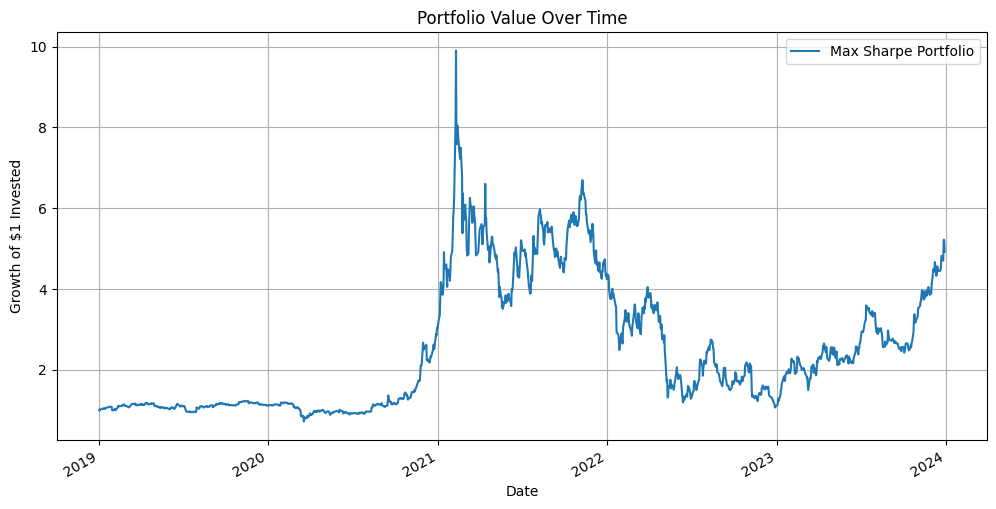

📈 Cumulative Return: 391.27%
📊 Annualized Volatility: 79.23%
⚖️ Sharpe Ratio: 0.77


C:\Users\chris\AppData\Local\Temp\ipykernel_1604\834792518.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cumulative_return = (portfolio_values[-1] / portfolio_values[0]) - 1


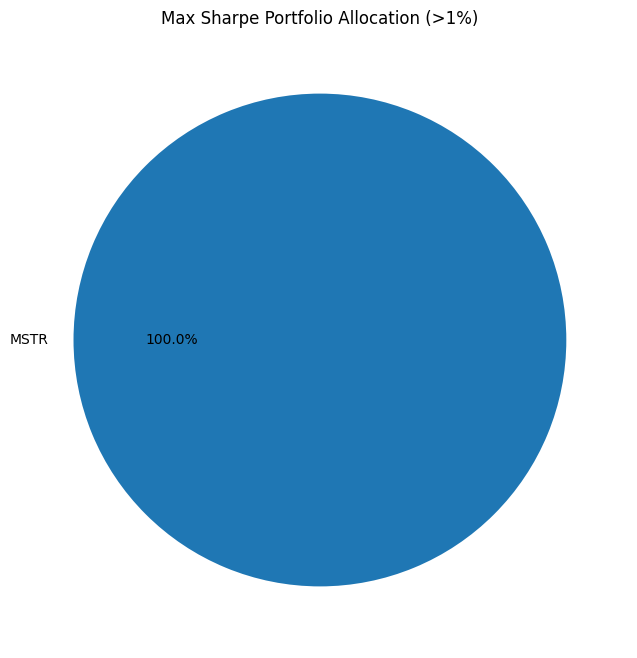

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load raw price data
prices = pd.read_csv("../data/raw/my_actual_portfolio.csv", index_col=0, parse_dates=True)

# Load Max Sharpe weights
sharpe_weights = pd.read_csv("../data/processed/max_sharpe_weights.csv", index_col=0).squeeze("columns")

# Normalize prices and multiply by weights
normalized = prices / prices.iloc[0]
portfolio_values = normalized.mul(sharpe_weights, axis=1).sum(axis=1)

# Plot
plt.figure(figsize=(12, 6))
portfolio_values.plot(label="Max Sharpe Portfolio")
plt.title("Portfolio Value Over Time")
plt.ylabel("Growth of $1 Invested")
plt.grid(True)
plt.legend()
plt.show()

# Daily returns
portfolio_returns = portfolio_values.pct_change().dropna()

# Performance metrics
cumulative_return = (portfolio_values[-1] / portfolio_values[0]) - 1
avg_daily_return = portfolio_returns.mean()
volatility = portfolio_returns.std()
sharpe_ratio = (avg_daily_return - 0.02/252) / volatility * np.sqrt(252)

print(f"📈 Cumulative Return: {cumulative_return:.2%}")
print(f"📊 Annualized Volatility: {volatility * np.sqrt(252):.2%}")
print(f"⚖️ Sharpe Ratio: {sharpe_ratio:.2f}")

plt.figure(figsize=(8, 8))
sharpe_weights[sharpe_weights > 0.01].plot.pie(autopct='%1.1f%%')
plt.title("Max Sharpe Portfolio Allocation (>1%)")
plt.ylabel("")
plt.show()

portfolio_values.to_csv("../outputs/results/max_sharpe_portfolio_value.csv")


[*********************100%***********************]  1 of 1 completed


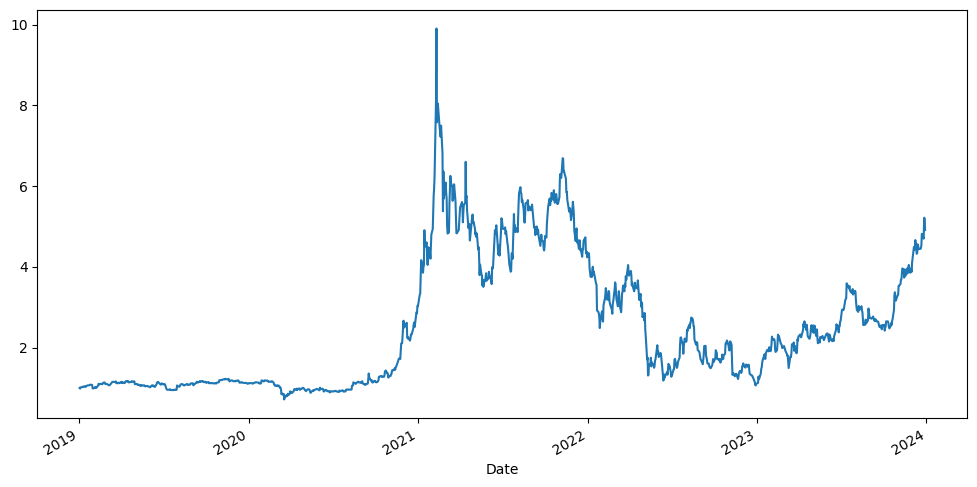

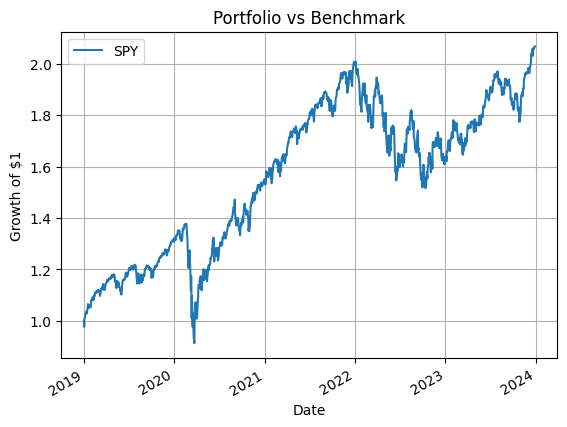

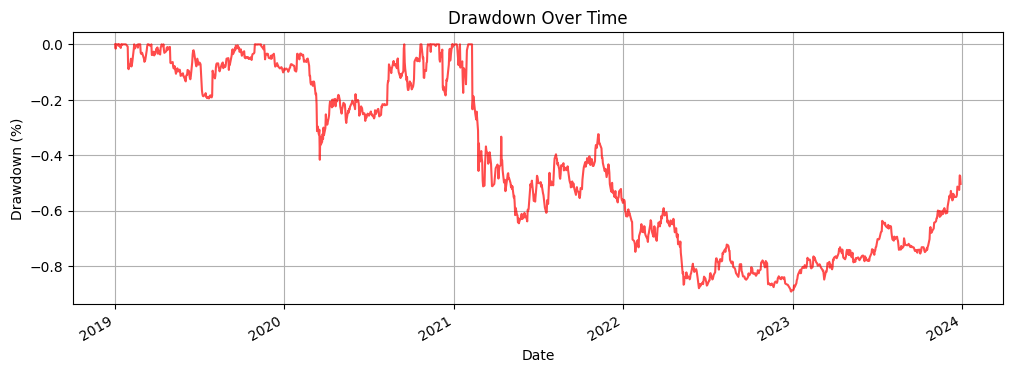

💔 Max Drawdown: -89.27%


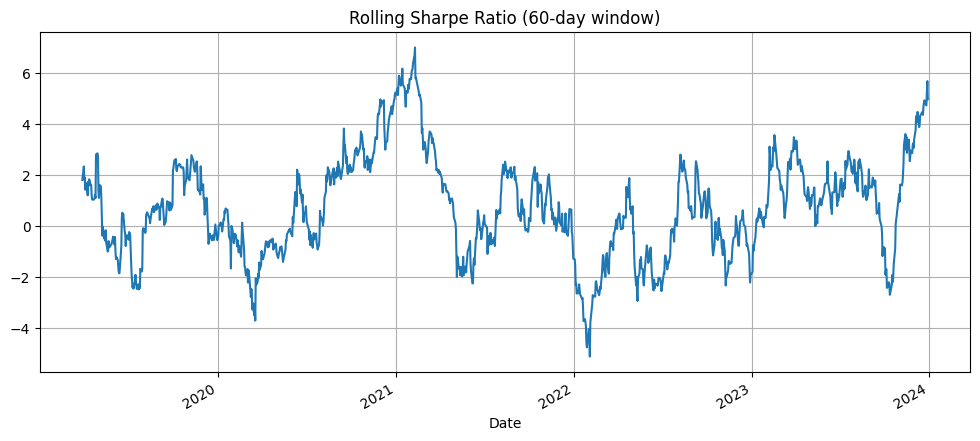

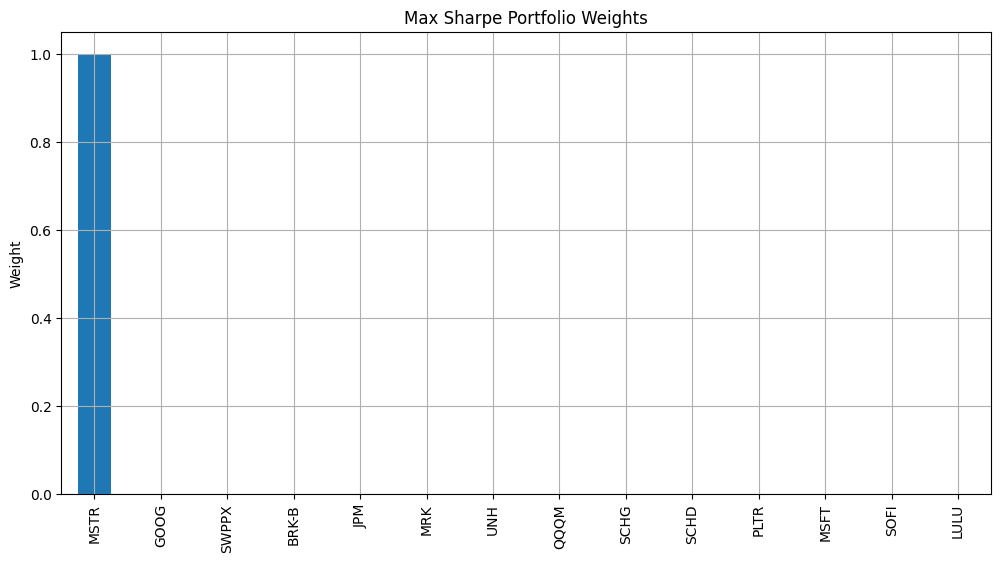

In [3]:
import yfinance as yf

spy_data = yf.download("SPY", start=portfolio_values.index[0], end=portfolio_values.index[-1])
spy = spy_data["Adj Close"] if "Adj Close" in spy_data else spy_data["Close"]

spy = spy / spy.iloc[0]  # normalize
portfolio_values_norm = portfolio_values / portfolio_values.iloc[0]

plt.figure(figsize=(12, 6))
portfolio_values_norm.plot(label="Max Sharpe Portfolio")
spy.plot(label="SPY Benchmark")
plt.legend()
plt.title("Portfolio vs Benchmark")
plt.ylabel("Growth of $1")
plt.grid(True)
plt.show()

rolling_max = portfolio_values.cummax()
drawdown = (portfolio_values - rolling_max) / rolling_max

plt.figure(figsize=(12, 4))
drawdown.plot(color='red', alpha=0.7)
plt.title("Drawdown Over Time")
plt.ylabel("Drawdown (%)")
plt.grid(True)
plt.show()

max_drawdown = drawdown.min()
print(f"💔 Max Drawdown: {max_drawdown:.2%}")

window = 60  # ~3 months
rolling_returns = portfolio_returns.rolling(window).mean()
rolling_vol = portfolio_returns.rolling(window).std()
rolling_sharpe = (rolling_returns / rolling_vol) * np.sqrt(252)

plt.figure(figsize=(12, 5))
rolling_sharpe.plot()
plt.title(f"Rolling Sharpe Ratio ({window}-day window)")
plt.grid(True)
plt.show()

sharpe_weights.sort_values(ascending=False).plot(kind='bar', figsize=(12, 6))
plt.title("Max Sharpe Portfolio Weights")
plt.ylabel("Weight")
plt.grid(True)
plt.show()

performance = {
    "Cumulative Return": cumulative_return,
    "Annualized Volatility": volatility * np.sqrt(252),
    "Sharpe Ratio": sharpe_ratio,
    "Max Drawdown": max_drawdown
}
pd.Series(performance).to_csv("../outputs/reports/max_sharpe_metrics.csv")
